In [1]:
import time
import datetime
import os
import numpy as np
import pandas as pd
import scipy
import pickle
import pyarrow.parquet as pq
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as m
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

# 1 Посмотрим на данные

In [2]:
# зададим путь к папке в которой будут находиться все данные
root = r'C:\Users\Верт-Миллер\Desktop\jupyter\_RUTUBE\train_dataset_soc_dem_train'

## 1.1 Соберём все данные о просмотрах пользователей в один датафрейм, используем длительность просмотра видео и общую его продолжительность для определения рейтинга видео по пользователю, затем сохраним данные в файл **parquet**, для дальнейшей аггрегации методами этой библиотеки

In [3]:
%%time
all_events = pd.read_csv(os.path.join(root, 'all_events.csv'))
train_events = pd.read_csv(os.path.join(root, 'train_events.csv'))
all_video_history = pd.concat([train_events, all_events])
video_info_v2 = pd.read_csv(os.path.join(root, 'video_info_v2.csv'))
all_video_history = all_video_history[['viewer_uid', 'rutube_video_id', 'total_watchtime']]
all_video_history = all_video_history.merge(video_info_v2[['rutube_video_id', 'duration']], how = 'inner', on = ['rutube_video_id'])
all_video_history['reiting_video'] = all_video_history.total_watchtime * 1000 / all_video_history.duration
all_video_history.to_parquet(os.path.join(root, 'all_video_history.pqt'), engine='pyarrow')
data = pq.read_table(os.path.join(root, 'all_video_history.pqt'))
pd.DataFrame([(z.name, z.type) for z in data.schema], columns = [['field', 'type']])

CPU times: total: 24.7 s
Wall time: 26 s


,field,type
0,viewer_uid,int64
1,rutube_video_id,string
2,total_watchtime,int64
3,duration,int64
4,reiting_video,double


# СОХРАНИМ ФИКТИВНЫЙ **test_events.csv** (потом заменим его, когда получим реальный)

In [4]:
all_events.iloc[-20000:].to_csv(os.path.join(root, 'test_events.csv'), index=False)

### Примечание: в качестве рейтинга просмотренного пользователем видео мы поставили долю продолжительности просмотра этого видео пользователем от общей продолжительности данного видео

## 1.2 Формирование разряженной матрицы (scipy sparse matrix) 

Соберём матрицу **Users-Items**

- для каждого просмотра (это одна строка в файле) указано рассчитаный нами рейтинг просмотра, который и будем суммировать в значения матрицы 
- попутно сформируем словари - кодирующие реальные значения Users и Items (в нашем случае пользователей и видео) от нуля до их количества, так как дальше у нас будут только индексы строк и столбцов - которые по сути и будут являться ключами Users и Items соответственно

In [5]:
%%time
data_agg = data.select(['viewer_uid', 'rutube_video_id', 'reiting_video']).\
    group_by(['viewer_uid', 'rutube_video_id']).aggregate([('reiting_video', 'sum')])
video_set = set(data_agg.select(['rutube_video_id']).to_pandas()['rutube_video_id'])
print(f'{len(video_set)} urls')
video_dict = {video: rutube_video_id for video, rutube_video_id in zip(video_set, range(len(video_set)))}
rev_video_dict = {v: k for k, v in video_dict.items()}
user_set = set(data_agg.select(['viewer_uid']).to_pandas()['viewer_uid'])
print(f'{len(user_set)} users')
user_dict = {user: user_id for user, user_id in zip(user_set, range(len(user_set)))}
rev_user_dict = {v: k for k, v in user_dict.items()}

values = np.array(data_agg.select(['reiting_video_sum']).to_pandas()['reiting_video_sum'])
rows = np.array(data_agg.select(['viewer_uid']).to_pandas()['viewer_uid'].map(user_dict))
cols = np.array(data_agg.select(['rutube_video_id']).to_pandas()['rutube_video_id'].map(video_dict))
mat = scipy.sparse.coo_matrix((values, (rows, cols)), shape=(rows.max() + 1, cols.max() + 1))
mat


354367 urls
1140897 users
CPU times: total: 15.3 s
Wall time: 13.4 s


<COOrdinate sparse matrix of dtype 'float64'
	with 9235390 stored elements and shape (1140897, 354367)>

#### Сформировали матрицу 1140897 - пользователей на 354367 - видео, далее будем работать с ней

## 1.3 Факторизация разряженной матрицы (scipy sparse matrix) 

- используем подход, использующийся в рекомендательных системах: произведём разными методами декомпозицию (факторизацию) полученной матрицы на произведение двух матриц (приближенное), с указанием числа компонент, в результате получим первую матрицу, которая будет характеризовать пользователей

### 1.3.1 TruncatedSVD
- Усеченное сингулярное разложение — это метод снижения размерности, способный сохранить большую часть исходной информации. Этот метод особенно полезен в случаях, где данные имеют большое количество функций, что затрудняет выполнение эффективных вычислений или визуализацию данных.
- Это вариант сингулярного разложения (SVD), который аппроксимирует исходную матрицу, сохраняя только k верхних сингулярных значений и соответствующие им сингулярные векторы.

In [6]:
%%time
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=50, n_iter=30, random_state=42)
W = svd.fit_transform(mat)
usr_emb_svd = pd.DataFrame(W).reset_index()
usr_emb_svd.columns = ['viewer_uid'] + [f'svd_{i}' for i in usr_emb_svd.columns[1:]]
usr_emb_svd.viewer_uid = usr_emb_svd.viewer_uid.map(rev_user_dict)
usr_emb_svd.to_parquet(os.path.join(root, 'usr_emb_svd.pqt'), engine='pyarrow')
usr_emb_svd

CPU times: total: 3min 41s
Wall time: 2min 21s


,viewer_uid,svd_0,svd_1,svd_2,svd_3,svd_4,svd_5,svd_6,svd_7,svd_8,...,svd_40,svd_41,svd_42,svd_43,svd_44,svd_45,svd_46,svd_47,svd_48,svd_49
0,10485760,8.312269e-15,3.865373e-14,2.326514e-12,2.546804e-11,2.720169e-07,4.742851e-08,3.016689e-10,6.971165e-10,-0.000001,...,2.387256e-09,1.424165e-13,1.252489e-08,-0.000005,0.000003,2.439412e-09,-3.256219e-07,-8.259587e-08,-2.107806e-07,8.244593e-08
1,10485761,5.633937e-06,5.635075e-06,8.511943e-04,3.136406e-05,1.467520e+00,-2.382892e+00,8.050901e-05,-1.119714e-03,0.448908,...,1.715491e-04,2.332620e-07,-1.905953e-04,0.001613,0.002019,-2.958800e-04,3.069944e-01,-3.527142e-02,-1.125920e-02,4.408717e-04
2,10485762,1.225230e-06,1.691108e-06,5.048040e-05,7.813295e-05,5.131221e-01,1.711330e-01,5.295261e-05,2.944007e-03,-0.604730,...,1.737913e-04,4.632458e-09,6.704381e-04,-0.249654,0.065280,1.292370e-04,-3.895940e-03,-1.055040e-03,-5.020768e-02,9.213358e-04
3,10485763,2.130621e-05,3.337464e-08,1.351924e-07,8.180681e-07,1.651468e-03,-4.343630e-04,1.033618e-06,1.827661e-06,-0.002363,...,-3.635293e-04,-8.007470e-09,-3.044222e-05,-0.012118,0.000206,-4.590888e-05,1.428163e-03,-6.514832e-04,-3.028214e-03,-1.537916e-03
4,10485764,8.294133e-14,7.324433e-14,3.602705e-12,3.198091e-11,4.372764e-07,7.286548e-08,5.993367e-10,3.397837e-09,-0.000002,...,-1.956372e-09,3.218251e-13,9.447409e-09,-0.000001,0.000002,1.152799e-09,2.627045e-07,8.407742e-07,3.117859e-06,2.100886e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1140892,10485755,7.074236e-08,1.165859e-07,1.894845e-06,5.006630e-06,1.021444e-02,5.418722e-04,3.823303e-06,8.825165e-06,-0.013078,...,-1.710320e-05,-2.048153e-09,-4.585110e-05,0.018376,-0.007953,-1.060673e-05,-3.341358e-03,2.713627e-04,2.573355e-03,-2.517258e-04
1140893,10485756,3.674858e-07,6.318179e-08,1.038558e-06,8.381766e-08,2.509572e-03,-1.166892e-03,-3.079198e-09,4.032821e-07,-0.001491,...,-8.897941e-07,-1.179886e-10,-7.609351e-07,0.001214,0.000017,6.809455e-07,-2.522795e-03,1.128675e-04,5.745304e-04,3.179402e-05
1140894,10485757,7.176260e-07,1.168088e-06,2.679437e-05,6.487230e-05,2.701990e-01,6.415493e-02,5.738691e-05,6.321436e-04,-0.422541,...,1.799216e-04,-5.571086e-09,7.594933e-04,-0.292590,-0.158821,1.438188e-04,-1.768858e-03,-2.412016e-03,-3.197770e-02,-2.084791e-03
1140895,10485758,4.379332e-07,5.475497e-09,2.284282e-06,7.999519e-06,1.474464e-02,-3.096330e-03,3.384732e-06,3.779215e-06,-0.012546,...,2.395420e-05,-8.501817e-09,2.568654e-05,-0.000461,-0.004187,5.438018e-05,-1.274428e-02,5.707731e-05,5.496973e-02,-1.100565e-03


In [7]:
with open(os.path.join(root, 'svd.fct'), 'wb') as fp:
    pickle.dump(svd, fp)

### Получили разложение на 50 компонент, матрица W - это наш Embedding пользователей
- используя обратный словарь **rev_user_dict** сохраним эмбеддинг с указанием **viewer_uid** в файл **usr_emb_ымв.pqt**, для дальнейшего его использования при формировании итогового датасета для обучения моделей

### 1.3.2 NMF (Non-Negative Matrix Factorization)

- разложение на две неотрицательные матрицы (W, H), т.е. матрицы со всеми неотрицательными элементами, произведение которых аппроксимирует исходную неотрицательную матрицу X.

In [8]:
%%time
from sklearn.decomposition import NMF
nmf = NMF(n_components=50, random_state=42, verbose=1, max_iter=15)
W = nmf.fit_transform(mat)
usr_emb_nmf = pd.DataFrame(W).reset_index()
usr_emb_nmf.columns = ['viewer_uid'] + [f'nmf_{i}' for i in usr_emb_nmf.columns[1:]]
usr_emb_nmf.viewer_uid = usr_emb_nmf.viewer_uid.map(rev_user_dict)
usr_emb_nmf.to_parquet(os.path.join(root, 'usr_emb_nmf.pqt'), engine='pyarrow')
usr_emb_nmf

violation: 1.0
violation: 0.2837610113819069
violation: 0.13947121963459325
violation: 0.051611779404893206
violation: 0.023626835717271
violation: 0.013144453801533696
violation: 0.008514338744563681
violation: 0.0058211011991677625
violation: 0.004178343324550877
violation: 0.003392135909632956
violation: 0.0028989598480843974
violation: 0.0025692423680266654
violation: 0.002234097476780456
violation: 0.002046616706735424
violation: 0.0019018899686268124
CPU times: total: 3min 32s
Wall time: 2min 34s


,viewer_uid,nmf_0,nmf_1,nmf_2,nmf_3,nmf_4,nmf_5,nmf_6,nmf_7,nmf_8,...,nmf_40,nmf_41,nmf_42,nmf_43,nmf_44,nmf_45,nmf_46,nmf_47,nmf_48,nmf_49
0,10485760,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00
1,10485761,0.0,0.000000e+00,1.259300e-07,0.000000e+00,0.000000e+00,8.691868e-02,4.137201e-07,1.341413e-06,0.000000,...,5.525195e-06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.123716,0.000000,0.000000e+00,0.000000e+00
2,10485762,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.008713,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,2.096732e-05,0.000000e+00
3,10485763,0.0,0.000000e+00,0.000000e+00,1.018842e-08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,...,2.207126e-07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00
4,10485764,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.187888e-11,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,1.412825e-07,0.000000e+00,0.000000e+00,0.000000,0.000000,3.663491e-07,5.259331e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1140892,10485755,0.0,1.098265e-09,1.309691e-08,9.607858e-08,2.106825e-05,5.421503e-05,1.364383e-08,0.000000e+00,0.000022,...,0.000000e+00,3.235369e-09,2.751124e-07,1.955769e-03,3.183363e-04,0.000000e+00,0.000041,0.000034,3.503023e-06,1.338610e-05
1140893,10485756,0.0,7.921968e-10,8.138258e-09,0.000000e+00,5.664957e-06,1.421866e-04,0.000000e+00,0.000000e+00,0.000000,...,9.262990e-08,5.246196e-09,1.731989e-07,1.422828e-04,3.964377e-05,3.538426e-07,0.000000,0.000007,3.343769e-06,1.549040e-05
1140894,10485757,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000035,...,2.088410e-07,0.000000e+00,0.000000e+00,0.000000e+00,3.047196e-02,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00
1140895,10485758,0.0,0.000000e+00,6.068497e-09,1.938014e-07,3.420573e-05,5.434718e-04,2.999258e-08,0.000000e+00,0.000064,...,2.740977e-06,2.608699e-09,1.966769e-06,7.081643e-04,1.644440e-04,4.506378e-06,0.000000,0.000004,3.470639e-06,2.148156e-03


In [9]:
with open(os.path.join(root, 'nmf.fct'), 'wb') as fp:
    pickle.dump(nmf, fp)

### Получили разложение на 50 компонент, матрица W - это наш Embedding пользователей
- используя обратный словарь **rev_user_dict** сохраним эмбеддинг с указанием **viewer_uid** в файл **usr_emb_nmf.pqt**, для дальнейшего его использования при формировании итогового датасета для обучения моделей

### ВАЖНО! При поступлении новых данных, в том числе тестовых, нам необходимо будет "пересобрать" матрицу с учётом новых данных и произвести обе факторизации для получения эмбеддингов, характеризующих новых пользователей, которые ранее нам не встречались. Это будет необходимо, чтобы получить предсказания с помощью уже обученной модели.

## 1.4 Далее будем работать только с данными из **train_events** (при поступлении тестовых данных  - **test_events**, проделаем с ними тоже самое чтобы получить предсказания с помощью уже обученной модели)

### 1.4.1 Соберём по пользователю в список все просмотренные им видео, используя файл с информацией о видео сформируем обработанный текст с описаниями всех видео

In [10]:
def user_text_video_description(lst):
    '''функция обрабатывает список из текстов, убирает ненужные символы и короткие слова'''
    return ' '.join([' '.join([''.join(e for e in j if e.isalnum()) for j in dict_video_descriptions[i].lower().split() if len(j) > 1]) for i in lst])

In [11]:
%%time
video_info_v2 = pd.read_csv(os.path.join(root, 'video_info_v2.csv'))
user_video_list = train_events.groupby('viewer_uid')['rutube_video_id'].agg(list).reset_index()
user_video_list.columns = ['viewer_uid', 'video_list']
user_video_list.video_list = user_video_list.video_list.map(lambda x: pd.Series(x).value_counts().index.tolist())
dict_video_descriptions = pd.Series(video_info_v2.title.values, index=video_info_v2.rutube_video_id).to_dict()
user_video_list['user_text_video_description'] = user_video_list.video_list.map(user_text_video_description)
user_video_text = user_video_list.drop(['video_list'], axis=1)
user_video_text.to_parquet(os.path.join(root, 'user_video_text.pqt'), engine='pyarrow')
user_video_text

CPU times: total: 56.8 s
Wall time: 56.8 s


,viewer_uid,user_text_video_description
0,10000001,экстрасенсы реванш сезон выпуск экстрасенсы ре...
1,10000002,сериал теория большого взрыва the big bang the...
2,10000004,космическая пенсия близнецы для богов ночной к...
3,10000005,как включить ccleaner россии
4,10000006,путешествие бессмертию 106 серия
...,...,...
180007,11140828,на что снимать блогеру айфон или камера
180008,11140869,на что снимать блогеру айфон или камера
180009,11140872,кто последний лопнет грелку стальные легкие фо...
180010,11140875,на что снимать блогеру айфон или камера


### Получили по каждому пользователю **user_text_video_description** - обработанный текст с названиями всех видео, просмотренных пользователем
- сохраним эти данные с указанием **viewer_uid** в файл **user_video_text.pqt**, для дальнейшего его использования при формировании итогового датасета для обучения моделей

### 1.4.2 Соберём по пользователю в список все просмотренные им видео, используя файл с информацией о видео сформируем обработанные текст с категориями видео b авторами видео

In [12]:
%%time
video_info_v2 = pd.read_csv(os.path.join(root, 'video_info_v2.csv'))
user_video_list = train_events.groupby('viewer_uid')['rutube_video_id'].agg(list).reset_index()
user_video_list.columns = ['viewer_uid', 'category_list']
user_video_list.category_list = user_video_list.category_list.map(lambda x: pd.Series(x).value_counts().index.tolist())
dict_video_category = pd.Series(video_info_v2.category.values, index=video_info_v2.rutube_video_id).to_dict()
user_video_list['category_text'] = user_video_list.category_list.map(lambda x: ' '.join(dict_video_category[i] for i in x))
user_video_category = user_video_list.drop(['category_list'], axis=1)
user_video_category.to_parquet(os.path.join(root, 'user_video_category.pqt'), engine='pyarrow')
user_video_category

CPU times: total: 42.8 s
Wall time: 42.8 s


,viewer_uid,category_text
0,10000001,Телепередачи Телепередачи Телепередачи Телепер...
1,10000002,Сериалы Сериалы Сериалы Сериалы Сериалы Сериал...
2,10000004,Наука Наука Технологии и интернет Обучение Обу...
3,10000005,Технологии и интернет
4,10000006,Аниме
...,...,...
180007,11140828,Обучение
180008,11140869,Обучение
180009,11140872,Развлечения Юмор Юмор Развлечения
180010,11140875,Обучение


In [13]:
%%time
video_info_v2 = pd.read_csv(os.path.join(root, 'video_info_v2.csv'))
user_video_list = train_events.groupby('viewer_uid')['rutube_video_id'].agg(list).reset_index()
user_video_list.columns = ['viewer_uid', 'author_id_list']
user_video_list.author_id_list = user_video_list.author_id_list.map(lambda x: pd.Series(x).value_counts().index.tolist())
dict_video_author_id = pd.Series(video_info_v2.author_id.values, index=video_info_v2.rutube_video_id).to_dict()
user_video_list['author_id_text'] = user_video_list['author_id_list'].map(lambda x: ' '.join(str(dict_video_author_id[i]) for i in x))
user_video_author_id = user_video_list.drop(['author_id_list'], axis=1)
user_video_author_id.to_parquet(os.path.join(root, 'user_video_author_id.pqt'), engine='pyarrow')
user_video_author_id

CPU times: total: 42.5 s
Wall time: 42.6 s


,viewer_uid,author_id_text
0,10000001,1009257 1009257 1009257 1009257 1009257 100925...
1,10000002,1065557 1065557 1065557 1065557 1065557 106555...
2,10000004,1010000 1010000 1010000 1010000 1010000 101000...
3,10000005,1025447
4,10000006,1028890
...,...,...
180007,11140828,1011978
180008,11140869,1011978
180009,11140872,1007052 1008930 1008930 1007052
180010,11140875,1011978


### Получили по каждому пользователю **category_text** - текст с категориями всех видео, просмотренных пользователем
- сохраним эти данные с указанием **viewer_uid** в файл **user_video_category.pqt**, для дальнейшего его использования при формировании итогового датасета для обучения моделей

### 1.4.3 Соберём по пользователю признаки - количество просмотренных видео и общая продолжительность просмотренных видео в часах

In [14]:
user_video_count = train_events.groupby('viewer_uid')['rutube_video_id'].agg('count').reset_index()
user_video_count.columns = ['viewer_uid', 'video_count']
user_video_duration = train_events.groupby('viewer_uid')['total_watchtime'].agg(sum).reset_index()
user_video_duration.columns = ['viewer_uid', 'duration']
user_video_duration.duration = user_video_duration.duration / 60
user_video_count = user_video_count.merge(user_video_duration, how = 'inner', on = ['viewer_uid'])
user_video_count

,viewer_uid,video_count,duration
0,10000001,19,1145.950000
1,10000002,9,253.666667
2,10000004,12,275.016667
3,10000005,1,3.533333
4,10000006,1,16.183333
...,...,...,...
180007,11140828,1,24.583333
180008,11140869,1,21.750000
180009,11140872,4,4.166667
180010,11140875,1,18.583333


### 1.4.4 Соберём по пользователю признаки регон, устройство, браузер, операционная система, название браузера по последнему просмотру видео, соединим их в один датафрейм с признаком из предыдщего пункта и сохраним для дальнейшего использования

In [15]:
user_region = train_events.groupby('viewer_uid')['region'].agg('last').reset_index()
user_region.columns = ['viewer_uid', 'region']
user_device = train_events.groupby('viewer_uid')['ua_device_type'].agg('last').reset_index()
user_device.columns = ['viewer_uid', 'device']
user_client_type = train_events.groupby('viewer_uid')['ua_client_type'].agg('last').reset_index()
user_client_type.columns = ['viewer_uid', 'client_type']
user_os = train_events.groupby('viewer_uid')['ua_os'].agg('last').reset_index()
user_os.columns = ['viewer_uid', 'os']
user_client_name = train_events.groupby('viewer_uid')['ua_client_name'].agg('last').reset_index()
user_client_name.columns = ['viewer_uid', 'client_name']

user_cat_features_1 = user_video_count.merge(user_region, how = 'inner', on = ['viewer_uid'])
user_cat_features_1 = user_cat_features_1.merge(user_device, how = 'inner', on = ['viewer_uid'])
user_cat_features_1 = user_cat_features_1.merge(user_client_type, how = 'inner', on = ['viewer_uid'])
user_cat_features_1 = user_cat_features_1.merge(user_os, how = 'inner', on = ['viewer_uid'])
user_cat_features_1 = user_cat_features_1.merge(user_client_name, how = 'inner', on = ['viewer_uid'])
user_cat_features_1.to_parquet(os.path.join(root, 'user_cat_features_1.pqt'), engine='pyarrow')
user_cat_features_1

,viewer_uid,video_count,duration,region,device,client_type,os,client_name
0,10000001,19,1145.950000,Moscow,desktop,browser,Windows,Chrome
1,10000002,9,253.666667,Moscow,tablet,mobile app,Android,Rutube
2,10000004,12,275.016667,Moscow,smartphone,mobile app,Android,Rutube
3,10000005,1,3.533333,Tatarstan Republic,desktop,browser,Windows,Yandex Browser
4,10000006,1,16.183333,Sverdlovsk Oblast,smartphone,mobile app,Android,Rutube
...,...,...,...,...,...,...,...,...
180007,11140828,1,24.583333,St.-Petersburg,tablet,browser,Android,Firefox Mobile
180008,11140869,1,21.750000,St.-Petersburg,tablet,browser,Android,Firefox Mobile
180009,11140872,4,4.166667,Kaliningrad Oblast,desktop,browser,Windows,Microsoft Edge
180010,11140875,1,18.583333,Moscow,tablet,browser,Android,Firefox Mobile


## 1.5 Сформируем дополнительные признаки для обучения модели используя метку времени просмотра

В данных для задачи "Предсказание социально-демографических характеристик пользователя" в колонке **event_timestamp** указано московское время (GMT +3). \
Используя данные из колонки **region** приведём время к региональному
- Файл **region_tz.csv** был сформирован при отдельном исследовании


In [16]:
train_events = pd.read_csv(os.path.join(root, 'train_events.csv'))

In [17]:
# приведение в соответствие типа данных даты события
train_events["event_timestamp"] = pd.to_datetime(train_events["event_timestamp"])

In [18]:
# загрузка данных с временными зонами регионов
region_tz = pd.read_csv(os.path.join(root, 'region_tz.csv'))
region_tz.head()

,Регион en,Регион ru,timezone,lat,lon
0,Kursk Oblast,Курск,UTC+3,51.7388,36.1874
1,Ulyanovsk,Ульяновск,UTC+4,54.3520,48.3663
2,Volgograd Oblast,Волгоград,UTC+4,48.7080,44.5130
3,Novgorod Oblast,Великий Новгород,UTC+3,58.5161,31.2756
4,Tambov Oblast,Тамбов,UTC+3,52.7311,41.4423


In [19]:
# объединение данных с историей просмотров и временными зонами регионов
train_events = train_events.merge(region_tz, left_on="region", right_on="Регион en")
train_events.head() 

,event_timestamp,region,ua_device_type,ua_client_type,ua_os,ua_client_name,total_watchtime,rutube_video_id,viewer_uid,Регион en,Регион ru,timezone,lat,lon
0,2024-06-01 06:40:58+03:00,Chelyabinsk,desktop,browser,Windows,Yandex Browser,1883,video_133074,10067243,Chelyabinsk,Челябинск,UTC+5,55.1644,61.4368
1,2024-06-01 19:33:24+03:00,Bashkortostan Republic,smartphone,mobile app,Android,Rutube,512,video_362960,10245341,Bashkortostan Republic,Уфа,UTC+5,54.7388,55.9721
2,2024-06-01 21:30:43+03:00,St.-Petersburg,desktop,browser,Windows,Chrome,5647,video_96775,10894333,St.-Petersburg,Санкт-Петербург,UTC+3,59.9343,30.3351
3,2024-06-01 23:03:42+03:00,Moscow,smartphone,mobile app,Android,Rutube,1521,video_161610,10029092,Moscow,Москва,UTC+3,55.7558,37.6173
4,2024-06-01 22:48:09+03:00,Moscow,smartphone,mobile app,Android,Rutube,71,video_116245,10452976,Moscow,Москва,UTC+3,55.7558,37.6173


In [20]:
def get_utc_tz(tz: str) -> int:
    """ получение часовой метки временной зоны

    Args:
        tz (str): временная зона

    Returns:
        int: часовая метка
    """

    return int(tz[3:])

In [21]:
train_events["timezone"] = train_events["timezone"].map(get_utc_tz)
train_events["gmt diff"] = train_events["timezone"] - 3

In [22]:
# получение регионального времени
current_event_time = []
# проход в цикле по дате события и разницы во времени относительно GMT + 3
for event_time, gmt_diff in train_events.iloc[:,[0, -1]].values:
    # разница во времени
    delta = datetime.timedelta(hours=gmt_diff)
    # получение регионально времени в зависимости от разницы во времени
    if gmt_diff < 0:
        current_event_time.append(event_time - delta)
    elif gmt_diff > 0:
        current_event_time.append(event_time + delta)
    else:
        current_event_time.append(event_time)

In [23]:
train_events["current_event_time"] = current_event_time

In [24]:
# очистка памяти
del current_event_time

In [25]:
# временной диапазон
train_events["current_event_time"].agg(["min", "max"])

min   2024-06-01 00:00:02+03:00
max   2024-07-01 08:40:13+03:00
Name: current_event_time, dtype: datetime64[ns, UTC+03:00]

Формирование признака времени дня 

00.00 до 06.00 **ночь** \
06.00 до 12.00 **утро** \
12.00 до 18.00 **день** \
18.00 до 00.00 **вечер**

In [26]:
# региональное время
train_events["current_time"] = train_events["current_event_time"].dt.time

In [27]:
# временные диапазоны времени суток
cut_labels = ["ночь", "утро", "день", "вечер"]
cut_bins = [datetime.time.fromisoformat("00:00:00"),
            datetime.time.fromisoformat("06:00:00"),
            datetime.time.fromisoformat("12:00:00"),
            datetime.time.fromisoformat("18:00:00"),
            datetime.time.fromisoformat("23:59:59")]

In [28]:
# временные диапазоны времени суток
train_events["time_cut"] = pd.cut(train_events["current_time"], bins=cut_bins, labels=cut_labels)

In [29]:
#  признак дня недели
train_events["current_weekday"] = train_events["current_event_time"].dt.weekday

In [30]:
def is_day_off(weekday: int) -> bool:
    """проверяет - является ли день просмотра выходным днём

    Args:
        weekday (int): день недели

    Returns:
        bool: является ли день просмотра выходным днём
    """
    return weekday in [5, 6]

In [31]:
#  признак выходного дня недели
train_events["is_day_off"] = train_events["current_weekday"].map(is_day_off) 

In [32]:
train_events_time = train_events[['viewer_uid', 'lat', 'lon', 'time_cut', 'current_weekday', 'is_day_off']]

In [33]:
train_events_lat = train_events_time.groupby('viewer_uid')['lat'].agg('last').reset_index()
train_events_lon = train_events_time.groupby('viewer_uid')['lon'].agg('last').reset_index()
train_events_fichi_time = train_events_lat.merge(train_events_lon, how = 'left', on = ['viewer_uid'])

df_temp = train_events_time[train_events_time['time_cut'] == 'ночь'].groupby('viewer_uid')['time_cut'].agg('count').reset_index()
df_temp.columns = ['viewer_uid', 'ночь']
train_events_fichi_time = train_events_fichi_time.merge(df_temp, how = 'left', on = ['viewer_uid'])

df_temp = train_events_time[train_events_time['time_cut'] == 'утро'].groupby('viewer_uid')['time_cut'].agg('count').reset_index()
df_temp.columns = ['viewer_uid', 'утро']
train_events_fichi_time = train_events_fichi_time.merge(df_temp, how = 'left', on = ['viewer_uid'])

df_temp = train_events_time[train_events_time['time_cut'] == 'день'].groupby('viewer_uid')['time_cut'].agg('count').reset_index()
df_temp.columns = ['viewer_uid', 'день']
train_events_fichi_time = train_events_fichi_time.merge(df_temp, how = 'left', on = ['viewer_uid'])

df_temp = train_events_time[train_events_time['time_cut'] == 'вечер'].groupby('viewer_uid')['time_cut'].agg('count').reset_index()
df_temp.columns = ['viewer_uid', 'вечер']
train_events_fichi_time = train_events_fichi_time.merge(df_temp, how = 'left', on = ['viewer_uid'])

for i in range(7):
    df_temp = train_events_time[train_events_time['current_weekday'] == i].groupby('viewer_uid')['time_cut'].agg('count').reset_index()
    df_temp.columns = ['viewer_uid', f'{i}-день']
    train_events_fichi_time = train_events_fichi_time.merge(df_temp, how = 'left', on = ['viewer_uid'])
    
df_temp = train_events_time[train_events_time['is_day_off'] == True].groupby('viewer_uid')['time_cut'].agg('count').reset_index()
df_temp.columns = ['viewer_uid', f'выходной день']
train_events_fichi_time = train_events_fichi_time.merge(df_temp, how = 'left', on = ['viewer_uid'])
train_events_fichi_time = train_events_fichi_time.fillna(0)
train_events_fichi_time.to_parquet(os.path.join(root, 'train_events_fichi_time.pqt'), engine='pyarrow')

### 1.5.1 Добавим статистические признаки по просмотрам видео

In [34]:
video_info_text_count = pd.read_csv(os.path.join(root, 'video_info_text_count.csv'))
video_info_text_count = train_events[['viewer_uid', 'rutube_video_id']].merge(video_info_text_count, how = 'left', on = ['rutube_video_id'])

In [35]:
video_info_text_count = video_info_text_count.groupby('viewer_uid').agg(
    text_male_count = ('text_male_count', 'mean'),
    text_female_count = ('text_female_count', 'mean'),
    text_age_0_class_count = ('text_age_0_class_count', 'mean'),
    text_age_1_class_count = ('text_age_1_class_count', 'mean'),
    text_age_2_class_count = ('text_age_2_class_count', 'mean'),
    text_age_3_class_count = ('text_age_3_class_count', 'mean')
                                                ).reset_index()
video_info_text_count.to_parquet(os.path.join(root, 'video_info_text_count.pqt'), engine='pyarrow')

## 1.6 Используем все файлы и соберём итоговый датасет

In [36]:
train_targets = pd.read_csv(os.path.join(root, 'train_targets.csv'))

In [37]:
usr_emb_svd = pd.read_parquet(os.path.join(root, 'usr_emb_svd.pqt'), engine='pyarrow')
usr_emb_nmf = pd.read_parquet(os.path.join(root, 'usr_emb_nmf.pqt'), engine='pyarrow')
user_video_text = pd.read_parquet(os.path.join(root, 'user_video_text.pqt'), engine='pyarrow')
user_video_category = pd.read_parquet(os.path.join(root, 'user_video_category.pqt'), engine='pyarrow')
user_video_author_id = pd.read_parquet(os.path.join(root, 'user_video_author_id.pqt'), engine='pyarrow')
user_cat_features_1 = pd.read_parquet(os.path.join(root, 'user_cat_features_1.pqt'), engine='pyarrow')
train_events_fichi_time = pd.read_parquet(os.path.join(root, 'train_events_fichi_time.pqt'), engine='pyarrow')
video_info_text_count = pd.read_parquet(os.path.join(root, 'video_info_text_count.pqt'), engine='pyarrow')
cat_features_1 = ['region',	'device', 'client_type', 'os', 'client_name']
for feature in cat_features_1:
   user_cat_features_1[f'{feature}'] = user_cat_features_1[f'{feature}'].fillna('unknown').astype('category')

In [38]:
train = train_targets.merge(user_video_text, how = 'inner', on = ['viewer_uid'])
train = train.merge(user_video_category, how = 'inner', on = ['viewer_uid'])
train = train.merge(user_video_author_id, how = 'inner', on = ['viewer_uid'])
train = train.merge(usr_emb_svd, how = 'inner', on = ['viewer_uid'])
train = train.merge(usr_emb_nmf, how = 'inner', on = ['viewer_uid'])
train = train.merge(user_cat_features_1, how = 'inner', on = ['viewer_uid'])
train = train.merge(train_events_fichi_time, how = 'inner', on = ['viewer_uid'])
train = train.merge(video_info_text_count, how = 'inner', on = ['viewer_uid'])

# 2. Валидация моделей

## 2.1 Подготовим выборки, определим текстовые и категориальные признаки

In [39]:
X = train.drop(['viewer_uid', 'age', 'sex', 'age_class'], axis = 1) #'viewer_uid', 
y_sex = train['sex'].map(lambda x: 1 if str(x) == 'male' else 0)
y_age = train['age_class']
cat_features = [i for i in X.columns if X.dtypes[i] == 'category']
text_features=[i for i in X.columns if X.dtypes[i] == 'object']
print(f'cat_features', cat_features)
print(f'text_features', text_features)

cat_features ['region', 'device', 'client_type', 'os', 'client_name']
text_features ['user_text_video_description', 'category_text', 'author_id_text']


## 2.2 ПОЛ (бинарная классификация)
- разделим выборку на обучающую и тестовую (валидационную)
- произведём поиск лучших гиперпараметров на валидации

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y_sex, test_size = 0.20, stratify=y_sex, random_state = 42)

In [41]:
train_pool_sex = Pool(
        X_train, 
        y_train, 
        cat_features=cat_features,
        text_features=text_features,
        feature_names=list(X_train)
    )
test_pool_sex = Pool(
        X_test, 
        y_test, 
        cat_features=cat_features,
        text_features=text_features,
        feature_names=list(X_train)
    )

In [42]:
%%time
clf_sex = CatBoostClassifier(random_state=42,
                             task_type='GPU',
                             learning_rate=0.002,
                             iterations=13000,
                             cat_features=cat_features,
                             text_features=text_features,
                             eval_metric='Accuracy') # 'AUC', 'F1'
clf_sex.fit(train_pool_sex, eval_set=test_pool_sex, verbose=500, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.7597025	test: 0.7675194	best: 0.7675194 (0)	total: 257ms	remaining: 55m 44s
500:	learn: 0.7643064	test: 0.7706024	best: 0.7706858 (496)	total: 15.9s	remaining: 6m 36s
1000:	learn: 0.7670562	test: 0.7725467	best: 0.7725745 (994)	total: 33.2s	remaining: 6m 38s
1500:	learn: 0.7690630	test: 0.7731022	best: 0.7735466 (1454)	total: 49.9s	remaining: 6m 22s
2000:	learn: 0.7705421	test: 0.7733522	best: 0.7735744 (1925)	total: 1m 6s	remaining: 6m 7s
2500:	learn: 0.7715559	test: 0.7749632	best: 0.7750187 (2472)	total: 1m 21s	remaining: 5m 44s
3000:	learn: 0.7726878	test: 0.7760742	best: 0.7761853 (2994)	total: 1m 36s	remaining: 5m 22s
3500:	learn: 0.7737711	test: 0.7766853	best: 0.7767964 (3481)	total: 1m 51s	remaining: 5m 2s
4000:	learn: 0.7746113	test: 0.7772408	best: 0.7774352 (3907)	total: 2m 6s	remaining: 4m 43s
4500:	learn: 0.7753821	test: 0.7776296	best: 0.7777685 (4442)	total: 2m 21s	remaining: 4m 27s
5000:	learn: 0.7758890	test: 0.7782963	best: 0.7783796 (4914)	total: 2m 37s	

In [43]:
print(f'ROC_AUC по полу {m.roc_auc_score(y_test, clf_sex.predict_proba(X_test)[:,1]):2.5f}')
print(f'Accuracy по полу {m.accuracy_score(y_test.values, clf_sex.predict(X_test)):2.5f}')

ROC_AUC по полу 0.87000
Accuracy по полу 0.77994


## 2.3 ВОЗРАСТ (мультиклассовая классификация)
- разделим выборку на обучающую и тестовую (валидационную)
- произведём поиск лучших гиперпараметров на валидации

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y_age, test_size = 0.20, stratify=y_age, random_state = 42)

In [45]:
train_pool_age = Pool(
        X_train, 
        y_train, 
        cat_features=cat_features,
        text_features=text_features,
        feature_names=list(X_train)
    )
test_pool_age = Pool(
        X_test, 
        y_test, 
        cat_features=cat_features,
        text_features=text_features,
        feature_names=list(X_train)
    ) 

In [46]:
%%time
clf_age = CatBoostClassifier(random_state=42,
                             task_type='GPU',
                             learning_rate=0.004,
                             iterations=15000,
                             bagging_temperature=0,
                             loss_function='MultiClass',
                             cat_features=cat_features,
                             text_features=text_features,
                             eval_metric='TotalF1') #
clf_age.fit(train_pool_age, eval_set=test_pool_age, verbose=500, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.4367105	test: 0.4421842	best: 0.4421842 (0)	total: 332ms	remaining: 1h 22m 52s
500:	learn: 0.4777944	test: 0.4771789	best: 0.4772062 (497)	total: 16.7s	remaining: 8m 4s
1000:	learn: 0.4901684	test: 0.4901725	best: 0.4903112 (992)	total: 33s	remaining: 7m 40s
1500:	learn: 0.4973878	test: 0.4974262	best: 0.4974694 (1496)	total: 49.1s	remaining: 7m 21s
2000:	learn: 0.5015232	test: 0.4980138	best: 0.4983121 (1902)	total: 1m 4s	remaining: 6m 58s
2500:	learn: 0.5056417	test: 0.5018644	best: 0.5019450 (2498)	total: 1m 20s	remaining: 6m 40s
3000:	learn: 0.5084298	test: 0.5042732	best: 0.5042993 (2999)	total: 1m 35s	remaining: 6m 22s
3500:	learn: 0.5110070	test: 0.5047287	best: 0.5048592 (3495)	total: 1m 51s	remaining: 6m 6s
4000:	learn: 0.5129298	test: 0.5055343	best: 0.5056809 (3938)	total: 2m 7s	remaining: 5m 49s
4500:	learn: 0.5150725	test: 0.5058790	best: 0.5062765 (4308)	total: 2m 23s	remaining: 5m 33s
5000:	learn: 0.5165388	test: 0.5062063	best: 0.5064059 (4905)	total: 2m 38s

In [47]:
y_pred = clf_age.predict(X_test).reshape(-1)
print(m.classification_report(y_test, y_pred, target_names = ['9-20 лет','21-30 лет', '31-40 лет', '41-60 лет'])) 
print(f"f1-weighted: {m.f1_score(y_test, y_pred, average='weighted'):.5f}")

              precision    recall  f1-score   support

    9-20 лет       0.99      0.06      0.11      1518
   21-30 лет       0.53      0.63      0.58     12627
   31-40 лет       0.49      0.45      0.47     13120
   41-60 лет       0.53      0.55      0.54      8738

    accuracy                           0.52     36003
   macro avg       0.64      0.42      0.42     36003
weighted avg       0.54      0.52      0.51     36003

f1-weighted: 0.50876


## 2.4 Оценим важность признаков (Feature importance)

In [48]:
def plot_feature_importance(importance, names, model_type):
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    data={'feature_names':feature_names,
          'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data) 
    fi_df.sort_values(by=['feature_importance'],    
                     ascending=False,inplace=True)
    plt.figure(figsize=(10,8))
    sns.barplot(x=fi_df['feature_importance'], 
               y=fi_df['feature_names'])
    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    plt.show()

### 2.4.1 Топ-15 важных признаков для предсказания пола 

In [49]:
importances = clf_sex.feature_importances_
feature_list = list(X.columns)
feature_results = pd.DataFrame({'feature': feature_list,'importance': importances})
feature_results = feature_results.sort_values('importance',ascending = False).reset_index(drop=True)

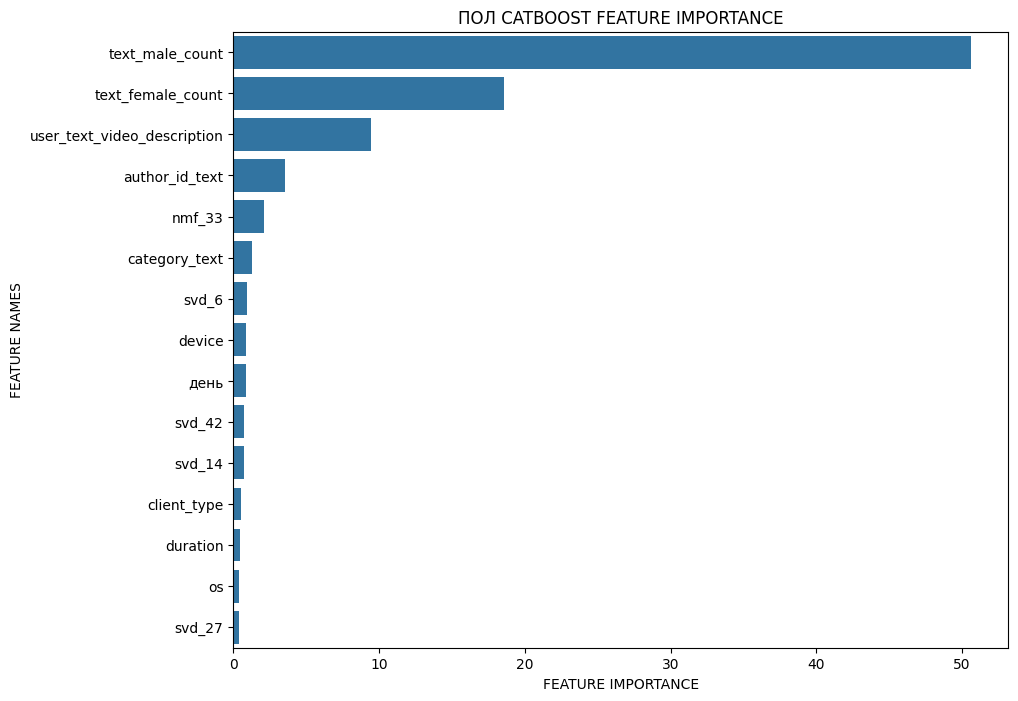

In [50]:
plot_feature_importance(feature_results[:15].importance, feature_results[:15].feature,'ПОЛ CATBOOST')

### 2.4.2 Топ-15 важных признаков для предсказания возраста

In [51]:
importances = clf_age.feature_importances_
feature_list = list(X.columns)
feature_results = pd.DataFrame({'feature': feature_list,'importance': importances})
feature_results = feature_results.sort_values('importance',ascending = False).reset_index(drop=True)

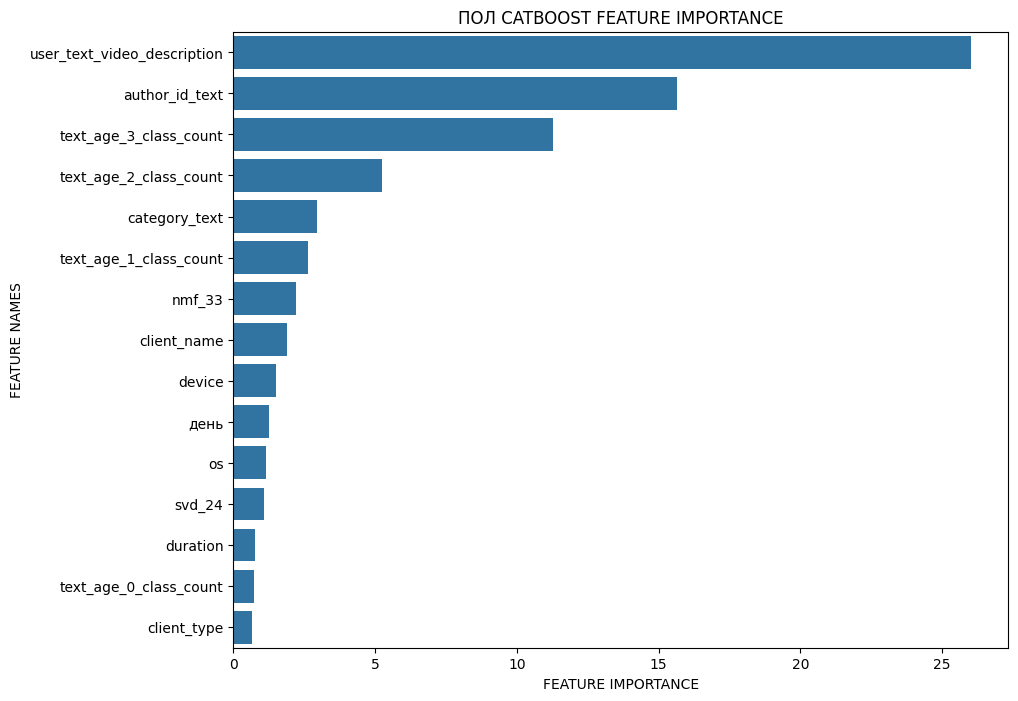

In [52]:
plot_feature_importance(feature_results[:15].importance, feature_results[:15].feature,'ПОЛ CATBOOST')

# 3. Оценка предсказания моделей в зависимости от активности пользователя (количества и общего времени просмотров)

- Будем разделять наши тестовые (валидационные) данные на категории в зависимости от количества просмотров и ощей длительности просмотров, затем посмотрим на метрики. У нас это признаки **video_count** и **duration** 


In [53]:
train_good = train[(train.video_count > 10) | (train.duration > 10)]
train_bad = train[(train.video_count < 10) & (train.duration < 10)]

In [54]:
X_good = train_good.drop(['viewer_uid', 'age', 'sex', 'age_class', ], axis = 1) #'viewer_uid', 
y_sex_good = train_good['sex'].map(lambda x: 1 if str(x) == 'male' else 0)
y_age_good = train_good['age_class']
cat_features = [i for i in X.columns if X.dtypes[i] == 'category']
text_features=[i for i in X.columns if X.dtypes[i] == 'object']
print(f'cat_features', cat_features)
print(f'text_features', text_features)

cat_features ['region', 'device', 'client_type', 'os', 'client_name']
text_features ['user_text_video_description', 'category_text', 'author_id_text']


In [55]:
X_bad = train_bad.drop(['viewer_uid', 'age', 'sex', 'age_class', ], axis = 1) #'viewer_uid', 
y_sex_bad = train_bad['sex'].map(lambda x: 1 if str(x) == 'male' else 0)
y_age_bad = train_bad['age_class']
cat_features = [i for i in X.columns if X.dtypes[i] == 'category']
text_features=[i for i in X.columns if X.dtypes[i] == 'object']
print(f'cat_features', cat_features)
print(f'text_features', text_features)

cat_features ['region', 'device', 'client_type', 'os', 'client_name']
text_features ['user_text_video_description', 'category_text', 'author_id_text']


## 3.1 Сравним метрики по предсказанию ПОЛА

In [56]:
print(f'ROC_AUC по полу {m.roc_auc_score(y_sex_good, clf_sex.predict_proba(X_good)[:,1]):2.5f}')
print(f'Accuracy по полу {m.accuracy_score(y_sex_good.values, clf_sex.predict(X_good)):2.5f}')

ROC_AUC по полу 0.88531
Accuracy по полу 0.80331


In [57]:
print(f'ROC_AUC по полу {m.roc_auc_score(y_sex_bad, clf_sex.predict_proba(X_bad)[:,1]):2.5f}')
print(f'Accuracy по полу {m.accuracy_score(y_sex_bad.values, clf_sex.predict(X_bad)):2.5f}')

ROC_AUC по полу 0.73963
Accuracy по полу 0.71285


## 3.2 Сравним метрики по предсказанию ВОЗРАСТА

In [58]:
y_pred_good = clf_age.predict(X_good).reshape(-1)
print(m.classification_report(y_age_good, y_pred_good, target_names = ['9-20 лет','21-30 лет', '31-40 лет', '41-60 лет'])) #, target_names = ['9-20','21-30', '31-40', '41-60']
print(f"f1-weighted: {m.f1_score(y_age_good, y_pred_good, average='weighted'):.5f}")

              precision    recall  f1-score   support

    9-20 лет       0.98      0.06      0.11      6272
   21-30 лет       0.56      0.70      0.62     51643
   31-40 лет       0.54      0.49      0.52     52656
   41-60 лет       0.59      0.55      0.57     35321

    accuracy                           0.56    145892
   macro avg       0.67      0.45      0.45    145892
weighted avg       0.58      0.56      0.55    145892

f1-weighted: 0.54831


In [59]:
y_pred_bad = clf_age.predict(X_bad).reshape(-1)
print(m.classification_report(y_age_bad, y_pred_bad, target_names = ['9-20 лет','21-30 лет', '31-40 лет', '41-60 лет'])) #, target_names = ['9-20','21-30', '31-40', '41-60']
print(f"f1-weighted: {m.f1_score(y_age_bad, y_pred_bad, average='weighted'):.5f}")

              precision    recall  f1-score   support

    9-20 лет       1.00      0.07      0.13      1316
   21-30 лет       0.54      0.50      0.52     11464
   31-40 лет       0.50      0.44      0.47     12920
   41-60 лет       0.52      0.74      0.61      8352

    accuracy                           0.52     34052
   macro avg       0.64      0.44      0.43     34052
weighted avg       0.54      0.52      0.51     34052

f1-weighted: 0.50758


## В результате исследований мы пришли к выводу, что пользователи, которые просмотрели менее 10 видео, а также общая длительность просмотра видео у которых менее 10 минут плохо поддаются определению поло-возрастных характеристик.

# 4. Обучение моделей на всех данных, по которым имеются таргеты

In [60]:
X = train.drop(['viewer_uid', 'age', 'sex', 'age_class', ], axis = 1) #'viewer_uid', 
y_sex = train['sex'].map(lambda x: 1 if str(x) == 'male' else 0)
y_age = train['age_class']

In [61]:
train_pool_sex_deploy = Pool(
        X, 
        y_sex, 
        cat_features=cat_features,
        text_features=text_features,
        feature_names=list(X_train)
    )

In [62]:
%%time
clf_sex_deploy = CatBoostClassifier(random_state=42,
                             task_type='GPU',
                             learning_rate=0.002,
                             iterations=13000,
                             cat_features=cat_features,
                             text_features=text_features,
                             eval_metric='Accuracy') # 'AUC', 'F1'
clf_sex_deploy.fit(train_pool_sex_deploy, verbose=500, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.7620214	total: 220ms	remaining: 47m 34s
500:	learn: 0.7649157	total: 14.9s	remaining: 6m 11s
1000:	learn: 0.7676933	total: 30.8s	remaining: 6m 9s
1500:	learn: 0.7690821	total: 47.1s	remaining: 6m 1s
2000:	learn: 0.7707708	total: 1m 3s	remaining: 5m 47s
2500:	learn: 0.7719819	total: 1m 17s	remaining: 5m 26s
3000:	learn: 0.7729985	total: 1m 32s	remaining: 5m 7s
3500:	learn: 0.7740151	total: 1m 46s	remaining: 4m 48s
4000:	learn: 0.7748595	total: 2m	remaining: 4m 31s
4500:	learn: 0.7757316	total: 2m 14s	remaining: 4m 14s
5000:	learn: 0.7763260	total: 2m 28s	remaining: 3m 58s
5500:	learn: 0.7768815	total: 2m 42s	remaining: 3m 42s
6000:	learn: 0.7776148	total: 2m 56s	remaining: 3m 26s
6500:	learn: 0.7783037	total: 3m 10s	remaining: 3m 10s
7000:	learn: 0.7789703	total: 3m 24s	remaining: 2m 55s
7500:	learn: 0.7794925	total: 3m 39s	remaining: 2m 40s
8000:	learn: 0.7800591	total: 3m 54s	remaining: 2m 26s
8500:	learn: 0.7806480	total: 4m 8s	remaining: 2m 11s
9000:	learn: 0.7814646	tot

In [63]:
clf_sex_deploy.save_model(os.path.join(root, 'clf_sex_deploy.cbm'), format="cbm")

In [64]:
train_pool_age_deploy = Pool(
        X, 
        y_age, 
        cat_features=cat_features,
        text_features=text_features,
        feature_names=list(X_train)
    )

In [65]:
%%time
clf_age_deploy = CatBoostClassifier(random_state=42,
                             task_type='GPU',
                             learning_rate=0.004,
                             iterations=15000,
                             bagging_temperature=0,
                             loss_function='MultiClass',
                             cat_features=cat_features,
                             text_features=text_features,
                             eval_metric='TotalF1') 
clf_age_deploy.fit(train_pool_age_deploy, verbose=500, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.4591953	total: 331ms	remaining: 1h 22m 37s
500:	learn: 0.4784859	total: 18.1s	remaining: 8m 44s
1000:	learn: 0.4906641	total: 36.5s	remaining: 8m 29s
1500:	learn: 0.4971879	total: 53.8s	remaining: 8m 4s
2000:	learn: 0.5010697	total: 1m 10s	remaining: 7m 36s
2500:	learn: 0.5045042	total: 1m 26s	remaining: 7m 13s
3000:	learn: 0.5069093	total: 1m 43s	remaining: 6m 52s
3500:	learn: 0.5092429	total: 1m 59s	remaining: 6m 33s
4000:	learn: 0.5113547	total: 2m 16s	remaining: 6m 15s
4500:	learn: 0.5134960	total: 2m 33s	remaining: 5m 57s
5000:	learn: 0.5153649	total: 2m 49s	remaining: 5m 39s
5500:	learn: 0.5170094	total: 3m 6s	remaining: 5m 22s
6000:	learn: 0.5183049	total: 3m 23s	remaining: 5m 5s
6500:	learn: 0.5198418	total: 3m 40s	remaining: 4m 47s
7000:	learn: 0.5208262	total: 3m 56s	remaining: 4m 30s
7500:	learn: 0.5221438	total: 4m 13s	remaining: 4m 13s
8000:	learn: 0.5235515	total: 4m 30s	remaining: 3m 56s
8500:	learn: 0.5248220	total: 4m 46s	remaining: 3m 39s
9000:	learn: 0.52

In [66]:
clf_age_deploy.save_model(os.path.join(root, 'clf_age_deploy.cbm'), format="cbm")

# 5. Подготовка данных для предсказания

## 5.1 Соберём все данные (включая новые для предсказания) о просмотрах пользователей в один датафрейм, используем длительность просмотра видео и общую его продолжительность для определения рейтинга видео по пользователю, затем сохраним данные в файл parquet, для дальнейшей аггрегации методами этой библиотеки

In [67]:
%%time
all_events = pd.read_csv(os.path.join(root, 'all_events.csv'))
train_events = pd.read_csv(os.path.join(root, 'train_events.csv'))
test_events = pd.read_csv(os.path.join(root, 'test_events.csv')) # после получения теста
all_video_history = pd.concat([train_events, all_events]) # добавить test_events после получения теста
video_info_v2 = pd.read_csv(os.path.join(root, 'video_info_v2.csv'))
all_video_history = all_video_history[['viewer_uid', 'rutube_video_id', 'total_watchtime']]
all_video_history = all_video_history.merge(video_info_v2[['rutube_video_id', 'duration']], how = 'inner', on = ['rutube_video_id'])
all_video_history['reiting_video'] = all_video_history.total_watchtime * 1000 / all_video_history.duration
all_video_history.to_parquet(os.path.join(root, 'all_video_history_test.pqt'), engine='pyarrow')
data = pq.read_table(os.path.join(root, 'all_video_history_test.pqt'))
pd.DataFrame([(z.name, z.type) for z in data.schema], columns = [['field', 'type']])

CPU times: total: 25.1 s
Wall time: 24.1 s


,field,type
0,viewer_uid,int64
1,rutube_video_id,string
2,total_watchtime,int64
3,duration,int64
4,reiting_video,double


## 5.2 Соберём матрицу Users-Items с учётом новых данных для предсказания, факторизуем её теми же методами, как и для обучения, чтобы получить эмбеддинги пользователй для предсказания 

In [68]:
%%time
data_agg = data.select(['viewer_uid', 'rutube_video_id', 'reiting_video']).\
    group_by(['viewer_uid', 'rutube_video_id']).aggregate([('reiting_video', 'sum')])
video_set = set(data_agg.select(['rutube_video_id']).to_pandas()['rutube_video_id'])
print(f'{len(video_set)} urls')
video_dict = {video: rutube_video_id for video, rutube_video_id in zip(video_set, range(len(video_set)))}
rev_video_dict = {v: k for k, v in video_dict.items()}
user_set = set(data_agg.select(['viewer_uid']).to_pandas()['viewer_uid'])
print(f'{len(user_set)} users')
user_dict = {user: user_id for user, user_id in zip(user_set, range(len(user_set)))}
rev_user_dict = {v: k for k, v in user_dict.items()}

values = np.array(data_agg.select(['reiting_video_sum']).to_pandas()['reiting_video_sum'])
rows = np.array(data_agg.select(['viewer_uid']).to_pandas()['viewer_uid'].map(user_dict))
cols = np.array(data_agg.select(['rutube_video_id']).to_pandas()['rutube_video_id'].map(video_dict))
mat = scipy.sparse.coo_matrix((values, (rows, cols)), shape=(rows.max() + 1, cols.max() + 1))
mat

354367 urls
1140897 users
CPU times: total: 15 s
Wall time: 12.6 s


<COOrdinate sparse matrix of dtype 'float64'
	with 9235390 stored elements and shape (1140897, 354367)>

In [69]:
%%time
from sklearn.decomposition import TruncatedSVD
with open(os.path.join(root, 'svd.fct'), 'rb') as fp:
    svd = pickle.load(fp)
    W = svd.transform(mat)
    usr_emb_svd = pd.DataFrame(W).reset_index()
    usr_emb_svd.columns = ['viewer_uid'] + [f'svd_{i}' for i in usr_emb_svd.columns[1:]]
    usr_emb_svd.viewer_uid = usr_emb_svd.viewer_uid.map(rev_user_dict)
    usr_emb_svd.to_parquet(os.path.join(root, 'usr_emb_svd_test.pqt'), engine='pyarrow')
usr_emb_svd

CPU times: total: 4.86 s
Wall time: 4.7 s


,viewer_uid,svd_0,svd_1,svd_2,svd_3,svd_4,svd_5,svd_6,svd_7,svd_8,...,svd_40,svd_41,svd_42,svd_43,svd_44,svd_45,svd_46,svd_47,svd_48,svd_49
0,10485760,1.853904e-16,2.237609e-16,9.293225e-17,1.299595e-15,9.108884e-11,2.753418e-11,-1.604617e-14,4.878756e-13,-1.912201e-10,...,4.797679e-12,1.309800e-15,-1.551606e-12,6.832892e-10,3.890877e-10,1.721547e-10,-1.286079e-09,5.978284e-09,1.200222e-09,2.745090e-10
1,10485761,1.635578e-06,5.360517e-07,4.555029e-05,1.936924e-06,1.254898e-01,-2.174180e-01,4.745349e-06,-1.085413e-04,4.511846e-02,...,1.081291e-04,8.429028e-09,1.790118e-04,-3.088155e-02,6.525182e-03,1.267998e-04,4.188347e-01,-2.197480e-02,1.297721e-03,-1.528937e-05
2,10485762,1.020361e-07,1.357560e-07,6.561135e-06,6.195807e-06,8.092424e-02,4.146438e-02,-1.613064e-05,8.873997e-05,-9.751032e-02,...,-4.950459e-06,6.081379e-11,-9.697478e-06,3.630724e-03,5.135261e-03,1.675949e-06,-3.295814e-04,-8.112936e-05,1.649331e-03,-1.521007e-05
3,10485763,1.528689e-07,5.287670e-11,1.967488e-08,1.415233e-08,6.616354e-04,-8.196994e-04,-5.849329e-10,-3.631188e-07,1.118100e-05,...,-4.176010e-07,-1.392495e-10,-3.355166e-07,-5.366801e-07,2.140621e-04,-6.650790e-07,-1.308213e-03,9.014747e-06,6.114700e-05,1.246213e-05
4,10485764,1.649205e-12,6.972212e-15,1.873759e-12,2.012031e-12,1.000357e-07,-6.053206e-08,-8.028607e-12,6.358417e-11,-1.264945e-07,...,8.363507e-11,-4.270911e-14,1.446098e-08,5.477542e-08,1.448480e-08,2.900890e-10,6.658377e-07,-3.622951e-08,1.447113e-08,4.531151e-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1140892,10485755,5.637548e-09,2.649405e-09,1.826073e-07,9.042868e-07,2.050309e-03,-2.449112e-05,1.559793e-07,1.261725e-06,-2.521706e-03,...,-3.108419e-06,-3.597390e-10,-8.625993e-06,3.263866e-03,-1.732091e-03,-2.792284e-06,-1.970280e-04,-2.338365e-04,2.687470e-04,-4.135852e-05
1140893,10485756,4.873077e-13,1.528979e-12,6.242604e-10,4.087590e-10,2.208989e-05,-2.099515e-05,-3.154825e-09,-4.005459e-08,9.266157e-06,...,-1.473154e-10,1.455419e-11,-6.322564e-08,1.982405e-05,-9.841631e-06,-3.119064e-08,-6.733833e-06,3.527107e-07,-2.224318e-06,-1.563359e-07
1140894,10485757,1.712956e-12,8.946019e-16,7.106297e-14,2.876090e-14,1.851668e-09,-1.564099e-10,3.628704e-12,3.872060e-12,-4.207229e-09,...,3.251298e-10,3.329531e-16,2.139477e-10,1.131485e-08,-2.596275e-09,1.263904e-11,-1.176904e-08,2.897410e-10,1.635108e-08,4.731846e-09
1140895,10485758,1.985950e-12,4.607929e-14,9.386401e-12,1.498553e-11,3.610376e-07,-3.306531e-07,2.119117e-10,1.430736e-09,-6.167476e-07,...,-1.793543e-08,-6.791971e-13,2.147612e-08,7.280035e-07,1.881407e-06,1.208203e-09,6.062400e-06,2.657207e-06,4.998552e-06,5.459180e-05


In [70]:
%%time
from sklearn.decomposition import NMF
with open(os.path.join(root, 'nmf.fct'), 'rb') as fp:
    nmf = pickle.load(fp)
    W = nmf.transform(mat)
    usr_emb_nmf = pd.DataFrame(W).reset_index()
    usr_emb_nmf.columns = ['viewer_uid'] + [f'nmf_{i}' for i in usr_emb_nmf.columns[1:]]
    usr_emb_nmf.viewer_uid = usr_emb_nmf.viewer_uid.map(rev_user_dict)
    usr_emb_nmf.to_parquet(os.path.join(root, 'usr_emb_nmf_test.pqt'), engine='pyarrow')
usr_emb_nmf

violation: 1.0
violation: 0.02716410444749342
violation: 3.8351146518493064e-05
Converged at iteration 4
CPU times: total: 19.9 s
Wall time: 18.8 s


,viewer_uid,nmf_0,nmf_1,nmf_2,nmf_3,nmf_4,nmf_5,nmf_6,nmf_7,nmf_8,...,nmf_40,nmf_41,nmf_42,nmf_43,nmf_44,nmf_45,nmf_46,nmf_47,nmf_48,nmf_49
0,10485760,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,...,4.923394e-13,8.261893e-15,0.000000e+00,1.840260e-11,1.711241e-11,1.417528e-11,0.000000e+00,5.011654e-10,2.744892e-11,4.041816e-11
1,10485761,0.0,5.120846e-10,0.0,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2,10485762,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,8.718201e-03,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
3,10485763,0.0,0.000000e+00,0.0,0.000000e+00,1.140709e-06,0.000062,0.000000e+00,0.000000e+00,1.307692e-06,...,9.845340e-08,0.000000e+00,0.000000e+00,5.058471e-06,6.814492e-06,0.000000e+00,0.000000e+00,1.175862e-05,6.223089e-07,8.019966e-06
4,10485764,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000,2.806045e-13,0.000000e+00,1.276508e-08,...,3.040475e-11,0.000000e+00,1.149040e-09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.086989e-10,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1140892,10485755,0.0,0.000000e+00,0.0,1.651019e-08,3.539759e-06,0.000000,0.000000e+00,0.000000e+00,5.655880e-06,...,0.000000e+00,5.310984e-10,4.649189e-09,3.678081e-04,4.726245e-05,0.000000e+00,5.088361e-05,0.000000e+00,9.233686e-07,0.000000e+00
1140893,10485756,0.0,0.000000e+00,0.0,0.000000e+00,1.543685e-07,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,1.728611e-11,0.000000e+00,4.298383e-07,0.000000e+00,0.000000e+00,4.311361e-06,0.000000e+00,0.000000e+00,0.000000e+00
1140894,10485757,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000,2.325521e-15,0.000000e+00,0.000000e+00,...,3.123102e-11,0.000000e+00,1.804153e-11,4.606048e-10,0.000000e+00,0.000000e+00,1.608212e-10,2.991758e-10,1.650946e-10,1.341805e-09
1140895,10485758,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,1.503968e-12,0.000000e+00,...,0.000000e+00,0.000000e+00,5.599096e-10,0.000000e+00,0.000000e+00,0.000000e+00,2.077107e-07,0.000000e+00,6.152663e-07,1.504857e-05


### 5.3 Соберём по пользователю в список все просмотренные им видео, используя файл с информацией о видео сформируем обработанный текст с описаниями всех видео

In [71]:
def user_text_video_description(lst):
    '''функция обрабатывает список из текстов, убирает ненужные символы и короткие слова'''
    return ' '.join([' '.join([''.join(e for e in j if e.isalnum()) for j in dict_video_descriptions[i].lower().split() if len(j) > 1]) for i in lst])

In [72]:
%%time
video_info_v2 = pd.read_csv(os.path.join(root, 'video_info_v2.csv'))
user_video_list = test_events.groupby('viewer_uid')['rutube_video_id'].agg(list).reset_index()
user_video_list.columns = ['viewer_uid', 'video_list']
user_video_list.video_list = user_video_list.video_list.map(lambda x: pd.Series(x).value_counts().index.tolist())
dict_video_descriptions = pd.Series(video_info_v2.title.values, index=video_info_v2.rutube_video_id).to_dict()
user_video_list['user_text_video_description'] = user_video_list.video_list.map(user_text_video_description)
user_video_text = user_video_list.drop(['video_list'], axis=1)
user_video_text.to_parquet(os.path.join(root, 'user_video_text_test.pqt'), engine='pyarrow')
user_video_text

CPU times: total: 4.39 s
Wall time: 4.37 s


,viewer_uid,user_text_video_description
0,10000003,тьма сезон серия смотреть бесплатно
1,10001128,сообщество сезон серия паранормальное отцовств...
2,10001559,сергей караганов америка идет серии кризисов п...
3,10002319,памяти анастасии заворотнюк здоровье маргариты...
4,10002723,последний герой русский сезон выпуск сокровища...
...,...,...
10203,11140842,годзилла конг новая империя фильм 2024
10204,11140844,люпен сезон серия
10205,11140876,готэм сезон серия
10206,11140877,звёздные войны эпизод империя наносит ответный...


### 5.4 Соберём по пользователю в список все просмотренные им видео, используя файл с информацией о видео сформируем обработанные текст с категориями видео b авторами видео

In [73]:
%%time
video_info_v2 = pd.read_csv(os.path.join(root, 'video_info_v2.csv'))
user_video_list = test_events.groupby('viewer_uid')['rutube_video_id'].agg(list).reset_index()
user_video_list.columns = ['viewer_uid', 'category_list']
user_video_list.category_list = user_video_list.category_list.map(lambda x: pd.Series(x).value_counts().index.tolist())
dict_video_category = pd.Series(video_info_v2.category.values, index=video_info_v2.rutube_video_id).to_dict()
user_video_list['category_text'] = user_video_list.category_list.map(lambda x: ' '.join(dict_video_category[i] for i in x))
user_video_category = user_video_list.drop(['category_list'], axis=1)
user_video_category.to_parquet(os.path.join(root, 'user_video_category_test.pqt'), engine='pyarrow')
user_video_category

CPU times: total: 4.12 s
Wall time: 4.13 s


,viewer_uid,category_text
0,10000003,Сериалы
1,10001128,Сериалы Сериалы Юмор Сериалы Сериалы Юмор
2,10001559,Разное
3,10002319,Телепередачи
4,10002723,Телепередачи Телепередачи
...,...,...
10203,11140842,Фильмы
10204,11140844,Сериалы
10205,11140876,Сериалы
10206,11140877,Фильмы


In [74]:
%%time
video_info_v2 = pd.read_csv(os.path.join(root, 'video_info_v2.csv'))
user_video_list = test_events.groupby('viewer_uid')['rutube_video_id'].agg(list).reset_index()
user_video_list.columns = ['viewer_uid', 'author_id_list']
user_video_list.author_id_list = user_video_list.author_id_list.map(lambda x: pd.Series(x).value_counts().index.tolist())
dict_video_author_id = pd.Series(video_info_v2.author_id.values, index=video_info_v2.rutube_video_id).to_dict()
user_video_list['author_id_text'] = user_video_list['author_id_list'].map(lambda x: ' '.join(str(dict_video_author_id[i]) for i in x))
user_video_author_id = user_video_list.drop(['author_id_list'], axis=1)
user_video_author_id.to_parquet(os.path.join(root, 'user_video_author_id_test.pqt'), engine='pyarrow')
user_video_author_id

CPU times: total: 3.84 s
Wall time: 3.84 s


,viewer_uid,author_id_text
0,10000003,1036141
1,10001128,1043618 1043618 1006760 1043618 1043618 1006760
2,10001559,1009168
3,10002319,1008828
4,10002723,1002137 1009257
...,...,...
10203,11140842,1043618
10204,11140844,1036271
10205,11140876,1058110
10206,11140877,1001198


### 5.5 Соберём по пользователю признаки - количество просмотренных видео и общая продолжительность просмотренных видео в часах

In [75]:
user_video_count = test_events.groupby('viewer_uid')['rutube_video_id'].agg('count').reset_index()
user_video_count.columns = ['viewer_uid', 'video_count']
user_video_duration = test_events.groupby('viewer_uid')['total_watchtime'].agg(sum).reset_index()
user_video_duration.columns = ['viewer_uid', 'duration']
user_video_duration.duration = user_video_duration.duration / 60
user_video_count = user_video_count.merge(user_video_duration, how = 'inner', on = ['viewer_uid'])
user_video_count

,viewer_uid,video_count,duration
0,10000003,1,31.550000
1,10001128,6,91.450000
2,10001559,1,74.533333
3,10002319,1,7.516667
4,10002723,2,29.983333
...,...,...,...
10203,11140842,1,15.250000
10204,11140844,1,48.550000
10205,11140876,1,17.283333
10206,11140877,1,20.000000


### 5.6 Соберём по пользователю признаки регон, устройство, браузер, операционная система, название браузера по последнему просмотру видео, соединим их в один датафрейм с признаком из предыдщего пункта и сохраним для дальнейшего использования

In [76]:
user_region = test_events.groupby('viewer_uid')['region'].agg('last').reset_index()
user_region.columns = ['viewer_uid', 'region']
user_device = test_events.groupby('viewer_uid')['ua_device_type'].agg('last').reset_index()
user_device.columns = ['viewer_uid', 'device']
user_client_type = test_events.groupby('viewer_uid')['ua_client_type'].agg('last').reset_index()
user_client_type.columns = ['viewer_uid', 'client_type']
user_os = test_events.groupby('viewer_uid')['ua_os'].agg('last').reset_index()
user_os.columns = ['viewer_uid', 'os']
user_client_name = test_events.groupby('viewer_uid')['ua_client_name'].agg('last').reset_index()
user_client_name.columns = ['viewer_uid', 'client_name']

user_cat_features_1 = user_video_count.merge(user_region, how = 'inner', on = ['viewer_uid'])
user_cat_features_1 = user_cat_features_1.merge(user_device, how = 'inner', on = ['viewer_uid'])
user_cat_features_1 = user_cat_features_1.merge(user_client_type, how = 'inner', on = ['viewer_uid'])
user_cat_features_1 = user_cat_features_1.merge(user_os, how = 'inner', on = ['viewer_uid'])
user_cat_features_1 = user_cat_features_1.merge(user_client_name, how = 'inner', on = ['viewer_uid'])
user_cat_features_1.to_parquet(os.path.join(root, 'user_cat_features_1_test.pqt'), engine='pyarrow')
user_cat_features_1

,viewer_uid,video_count,duration,region,device,client_type,os,client_name
0,10000003,1,31.550000,Moscow Oblast,desktop,browser,Windows,Opera
1,10001128,6,91.450000,Chelyabinsk,smartphone,mobile app,Android,Rutube
2,10001559,1,74.533333,Chelyabinsk,smartphone,mobile app,Android,Rutube
3,10002319,1,7.516667,Stavropol Kray,desktop,browser,Windows,Yandex Browser
4,10002723,2,29.983333,Moscow,smartphone,mobile app,Android,Rutube
...,...,...,...,...,...,...,...,...
10203,11140842,1,15.250000,Moscow,smartphone,mobile app,Android,Rutube
10204,11140844,1,48.550000,Tula Oblast,smartphone,mobile app,Android,Rutube
10205,11140876,1,17.283333,Moscow Oblast,tablet,mobile app,Android,Rutube
10206,11140877,1,20.000000,Vologda Oblast,smartphone,mobile app,Android,Rutube


### 5.7 Сформируем дополнительные признаки для предсказания модели используя метку времени просмотра

In [77]:
test_events = pd.read_csv(os.path.join(root, 'test_events.csv'))
test_events["event_timestamp"] = pd.to_datetime(test_events["event_timestamp"])
region_tz = pd.read_csv(os.path.join(root, 'region_tz.csv'))
test_events = test_events.merge(region_tz, left_on="region", right_on="Регион en")

In [78]:
def get_utc_tz(tz: str) -> int:
    """ получение часовой метки временной зоны

    Args:
        tz (str): временная зона

    Returns:
        int: часовая метка
    """

    return int(tz[3:])

In [79]:
test_events["timezone"] = test_events["timezone"].map(get_utc_tz)
test_events["gmt diff"] = test_events["timezone"] - 3

In [80]:
# получение регионального времени
current_event_time = []
# проход в цикле по дате события и разницы во времени относительно GMT + 3
for event_time, gmt_diff in test_events.iloc[:,[0, -1]].values:
    # разница во времени
    delta = datetime.timedelta(hours=gmt_diff)
    # получение регионально времени в зависимости от разницы во времени
    if gmt_diff < 0:
        current_event_time.append(event_time - delta)
    elif gmt_diff > 0:
        current_event_time.append(event_time + delta)
    else:
        current_event_time.append(event_time)

In [81]:
test_events["current_event_time"] = current_event_time

In [82]:
del current_event_time

In [83]:
# временной диапазон
test_events["current_event_time"].agg(["min", "max"])

min   2024-06-30 00:00:04+03:00
max   2024-07-01 08:38:41+03:00
Name: current_event_time, dtype: datetime64[ns, UTC+03:00]

In [84]:
# региональное время
test_events["current_time"] = test_events["current_event_time"].dt.time

In [85]:
# временные диапазоны времени суток
cut_labels = ["ночь", "утро", "день", "вечер"]
cut_bins = [datetime.time.fromisoformat("00:00:00"),
            datetime.time.fromisoformat("06:00:00"),
            datetime.time.fromisoformat("12:00:00"),
            datetime.time.fromisoformat("18:00:00"),
            datetime.time.fromisoformat("23:59:59")]

In [86]:
# временные диапазоны времени суток
test_events["time_cut"] = pd.cut(test_events["current_time"], bins=cut_bins, labels=cut_labels)

In [87]:
#  признак дня недели
test_events["current_weekday"] = test_events["current_event_time"].dt.weekday

In [88]:
def is_day_off(weekday: int) -> bool:
    """проверяет - является ли день просмотра выходным днём

    Args:
        weekday (int): день недели

    Returns:
        bool: является ли день просмотра выходным днём
    """
    return weekday in [5, 6]

In [89]:
#  признак выходного дня недели
test_events["is_day_off"] = test_events["current_weekday"].map(is_day_off) 

In [90]:
test_events_time = test_events[['viewer_uid', 'lat', 'lon', 'time_cut', 'current_weekday', 'is_day_off']]

In [91]:
test_events_time

,viewer_uid,lat,lon,time_cut,current_weekday,is_day_off
0,10317890,43.1156,131.8851,утро,6,True
1,10546804,56.0153,92.8932,день,6,True
2,10670379,56.3269,44.0059,ночь,6,True
3,11028571,55.7558,37.6173,ночь,6,True
4,10432484,56.3269,44.0059,ночь,6,True
...,...,...,...,...,...,...
19995,10687999,56.3269,44.0059,вечер,6,True
19996,10425804,55.1644,61.4368,утро,6,True
19997,10565147,45.0355,38.9753,утро,6,True
19998,10715847,55.7558,37.6173,вечер,6,True


In [92]:
test_events_lat = test_events_time.groupby('viewer_uid')['lat'].agg('last').reset_index()
test_events_lon = test_events_time.groupby('viewer_uid')['lon'].agg('last').reset_index()
test_events_fichi_time = test_events_lat.merge(test_events_lon, how = 'left', on = ['viewer_uid'])

df_temp = test_events_time[test_events_time['time_cut'] == 'ночь'].groupby('viewer_uid')['time_cut'].agg('count').reset_index()
df_temp.columns = ['viewer_uid', 'ночь']
test_events_fichi_time = test_events_fichi_time.merge(df_temp, how = 'left', on = ['viewer_uid'])

df_temp = test_events_time[test_events_time['time_cut'] == 'утро'].groupby('viewer_uid')['time_cut'].agg('count').reset_index()
df_temp.columns = ['viewer_uid', 'утро']
test_events_fichi_time = test_events_fichi_time.merge(df_temp, how = 'left', on = ['viewer_uid'])

df_temp = test_events_time[test_events_time['time_cut'] == 'день'].groupby('viewer_uid')['time_cut'].agg('count').reset_index()
df_temp.columns = ['viewer_uid', 'день']
test_events_fichi_time = test_events_fichi_time.merge(df_temp, how = 'left', on = ['viewer_uid'])

df_temp = test_events_time[test_events_time['time_cut'] == 'вечер'].groupby('viewer_uid')['time_cut'].agg('count').reset_index()
df_temp.columns = ['viewer_uid', 'вечер']
test_events_fichi_time = test_events_fichi_time.merge(df_temp, how = 'left', on = ['viewer_uid'])


for i in range(7):
    df_temp = test_events_time[test_events_time['current_weekday'] == i].groupby('viewer_uid')['time_cut'].agg('count').reset_index()
    df_temp.columns = ['viewer_uid', f'{i}-день']
    test_events_fichi_time = test_events_fichi_time.merge(df_temp, how = 'left', on = ['viewer_uid'])
    
df_temp = test_events_time[test_events_time['is_day_off'] == True].groupby('viewer_uid')['time_cut'].agg('count').reset_index()
df_temp.columns = ['viewer_uid', f'выходной день']
test_events_fichi_time = test_events_fichi_time.merge(df_temp, how = 'left', on = ['viewer_uid'])
test_events_fichi_time = test_events_fichi_time.fillna(0)
test_events_fichi_time.to_parquet(os.path.join(root, 'test_events_fichi_time.pqt'), engine='pyarrow')
test_events_fichi_time

,viewer_uid,lat,lon,ночь,утро,день,вечер,0-день,1-день,2-день,3-день,4-день,5-день,6-день,выходной день
0,10000003,55.7558,37.6173,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,10001128,55.1644,61.4368,0.0,0.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,6.0
2,10001559,55.1644,61.4368,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
3,10002319,45.0443,41.9684,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
4,10002723,55.7558,37.6173,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10203,11140842,55.7558,37.6173,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
10204,11140844,54.1971,37.6135,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
10205,11140876,55.7558,37.6173,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
10206,11140877,59.2243,39.8910,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


### 5.7.1

In [93]:
video_info_text_count = pd.read_csv(os.path.join(root, 'video_info_text_count.csv'))
video_info_text_count = test_events[['viewer_uid', 'rutube_video_id']].merge(video_info_text_count, how = 'left', on = ['rutube_video_id'])
video_info_text_count

,viewer_uid,rutube_video_id,text_male_count,text_female_count,text_age_0_class_count,text_age_1_class_count,text_age_2_class_count,text_age_3_class_count
0,10317890,video_374027,0,0,0,0,0,0
1,10546804,video_347605,0,0,0,0,0,0
2,10670379,video_378675,0,0,0,0,0,0
3,11028571,video_372327,0,0,0,0,0,0
4,10432484,video_356343,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
19995,10687999,video_163270,0,0,0,0,0,0
19996,10425804,video_433627,0,0,0,0,0,0
19997,10565147,video_11911,0,0,0,0,0,0
19998,10715847,video_252573,0,0,0,0,0,0


In [94]:
video_info_text_count = video_info_text_count.groupby('viewer_uid').agg(
    text_male_count = ('text_male_count', 'mean'),
    text_female_count = ('text_female_count', 'mean'),
    text_age_0_class_count = ('text_age_0_class_count', 'mean'),
    text_age_1_class_count = ('text_age_1_class_count', 'mean'),
    text_age_2_class_count = ('text_age_2_class_count', 'mean'),
    text_age_3_class_count = ('text_age_3_class_count', 'mean')
                                                ).reset_index()
video_info_text_count.to_parquet(os.path.join(root, 'video_info_text_count_test.pqt'), engine='pyarrow')

### 5.8 Используем все файлы и соберём итоговый датасет

In [95]:
usr_emb_svd = pd.read_parquet(os.path.join(root, 'usr_emb_svd_test.pqt'), engine='pyarrow')
usr_emb_nmf = pd.read_parquet(os.path.join(root, 'usr_emb_nmf_test.pqt'), engine='pyarrow')
user_video_text = pd.read_parquet(os.path.join(root, 'user_video_text_test.pqt'), engine='pyarrow')
user_video_category = pd.read_parquet(os.path.join(root, 'user_video_category_test.pqt'), engine='pyarrow')
user_video_author_id = pd.read_parquet(os.path.join(root, 'user_video_author_id_test.pqt'), engine='pyarrow')
user_cat_features_1 = pd.read_parquet(os.path.join(root, 'user_cat_features_1_test.pqt'), engine='pyarrow')
test_events_fichi_time = pd.read_parquet(os.path.join(root, 'test_events_fichi_time.pqt'), engine='pyarrow')
video_info_text_count = pd.read_parquet(os.path.join(root, 'video_info_text_count_test.pqt'), engine='pyarrow')
cat_features_1 = ['region',	'device', 'client_type', 'os', 'client_name']
for feature in cat_features_1:
   user_cat_features_1[f'{feature}'] = user_cat_features_1[f'{feature}'].fillna('unknown').astype('category')

In [96]:
test_id = test_events.groupby('viewer_uid')['rutube_video_id'].agg('count').reset_index()[['viewer_uid']]
test_id

,viewer_uid
0,10000003
1,10001128
2,10001559
3,10002319
4,10002723
...,...
10203,11140842
10204,11140844
10205,11140876
10206,11140877


In [97]:
test = test_id.merge(user_video_text, how = 'inner', on = ['viewer_uid'])
test = test.merge(user_video_category, how = 'inner', on = ['viewer_uid'])
test = test.merge(user_video_author_id, how = 'inner', on = ['viewer_uid'])
test = test.merge(usr_emb_svd, how = 'inner', on = ['viewer_uid'])
test = test.merge(usr_emb_nmf, how = 'inner', on = ['viewer_uid'])
test = test.merge(user_cat_features_1, how = 'inner', on = ['viewer_uid'])
test = test.merge(test_events_fichi_time, how = 'inner', on = ['viewer_uid'])
test = test.merge(video_info_text_count, how = 'inner', on = ['viewer_uid'])
test

,viewer_uid,user_text_video_description,category_text,author_id_text,svd_0,svd_1,svd_2,svd_3,svd_4,svd_5,...,4-день,5-день,6-день,выходной день,text_male_count,text_female_count,text_age_0_class_count,text_age_1_class_count,text_age_2_class_count,text_age_3_class_count
0,10000003,тьма сезон серия смотреть бесплатно,Сериалы,1036141,8.691930e-09,3.564701e-08,2.027068e-07,7.791410e-10,3.246673e-05,-4.417674e-05,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10001128,сообщество сезон серия паранормальное отцовств...,Сериалы Сериалы Юмор Сериалы Сериалы Юмор,1043618 1043618 1006760 1043618 1043618 1006760,7.463976e-12,7.414080e-13,4.464560e-11,2.663991e-10,4.976737e-06,2.089367e-06,...,0.0,0.0,6.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0
2,10001559,сергей караганов америка идет серии кризисов п...,Разное,1009168,2.649688e-08,4.985022e-12,6.364170e-10,2.369863e-09,5.618550e-05,1.691902e-05,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10002319,памяти анастасии заворотнюк здоровье маргариты...,Телепередачи,1008828,3.308543e-13,2.868208e-13,1.330205e-10,2.870343e-11,3.233912e-06,-7.410364e-06,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,10002723,последний герой русский сезон выпуск сокровища...,Телепередачи Телепередачи,1002137 1009257,2.251953e-08,5.595894e-11,2.860911e-07,1.043078e-07,6.695962e-04,8.819870e-05,...,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10203,11140842,годзилла конг новая империя фильм 2024,Фильмы,1043618,-2.626379e-135,1.991744e-130,1.809799e-130,-1.925152e-130,-7.254278e-130,-2.499705e-129,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
10204,11140844,люпен сезон серия,Сериалы,1036271,5.286915e-13,1.437196e-16,1.208316e-14,3.118949e-15,2.181054e-10,-1.414808e-10,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
10205,11140876,готэм сезон серия,Сериалы,1058110,3.188908e-154,-1.617056e-150,-7.761489e-150,2.449434e-149,-3.705334e-149,6.410546e-149,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
10206,11140877,звёздные войны эпизод империя наносит ответный...,Фильмы,1001198,-2.122031e-185,1.787070e-179,1.199989e-179,1.108832e-180,-1.225929e-178,8.078092e-179,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [98]:
X_test = test.drop(['viewer_uid'], axis = 1)
cat_features = [i for i in X.columns if X.dtypes[i] == 'category']
text_features=[i for i in X.columns if X.dtypes[i] == 'object']
print(f'cat_features', cat_features)
print(f'text_features', text_features)

cat_features ['region', 'device', 'client_type', 'os', 'client_name']
text_features ['user_text_video_description', 'category_text', 'author_id_text']


In [99]:
X_test

,user_text_video_description,category_text,author_id_text,svd_0,svd_1,svd_2,svd_3,svd_4,svd_5,svd_6,...,4-день,5-день,6-день,выходной день,text_male_count,text_female_count,text_age_0_class_count,text_age_1_class_count,text_age_2_class_count,text_age_3_class_count
0,тьма сезон серия смотреть бесплатно,Сериалы,1036141,8.691930e-09,3.564701e-08,2.027068e-07,7.791410e-10,3.246673e-05,-4.417674e-05,2.289258e-09,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,сообщество сезон серия паранормальное отцовств...,Сериалы Сериалы Юмор Сериалы Сериалы Юмор,1043618 1043618 1006760 1043618 1043618 1006760,7.463976e-12,7.414080e-13,4.464560e-11,2.663991e-10,4.976737e-06,2.089367e-06,1.413853e-09,...,0.0,0.0,6.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0
2,сергей караганов америка идет серии кризисов п...,Разное,1009168,2.649688e-08,4.985022e-12,6.364170e-10,2.369863e-09,5.618550e-05,1.691902e-05,1.293616e-09,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,памяти анастасии заворотнюк здоровье маргариты...,Телепередачи,1008828,3.308543e-13,2.868208e-13,1.330205e-10,2.870343e-11,3.233912e-06,-7.410364e-06,2.044616e-10,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,последний герой русский сезон выпуск сокровища...,Телепередачи Телепередачи,1002137 1009257,2.251953e-08,5.595894e-11,2.860911e-07,1.043078e-07,6.695962e-04,8.819870e-05,6.946845e-08,...,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10203,годзилла конг новая империя фильм 2024,Фильмы,1043618,-2.626379e-135,1.991744e-130,1.809799e-130,-1.925152e-130,-7.254278e-130,-2.499705e-129,3.588863e-129,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
10204,люпен сезон серия,Сериалы,1036271,5.286915e-13,1.437196e-16,1.208316e-14,3.118949e-15,2.181054e-10,-1.414808e-10,7.555969e-14,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
10205,готэм сезон серия,Сериалы,1058110,3.188908e-154,-1.617056e-150,-7.761489e-150,2.449434e-149,-3.705334e-149,6.410546e-149,-2.755738e-148,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
10206,звёздные войны эпизод империя наносит ответный...,Фильмы,1001198,-2.122031e-185,1.787070e-179,1.199989e-179,1.108832e-180,-1.225929e-178,8.078092e-179,1.451925e-178,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [100]:
set(X.columns) - set(X_test.columns)

set()

# 6. Получение предсказаний и формирование файла для направления в проверяющую систему

In [101]:
from catboost import CatBoostClassifier
model1 = CatBoostClassifier()
model2 = CatBoostClassifier()

In [102]:
clf_sex_deploy = model1.load_model(os.path.join(root, 'clf_sex_deploy.cbm'), format="cbm")

In [103]:
clf_age_deploy = model2.load_model(os.path.join(root, 'clf_age_deploy.cbm'), format="cbm")

In [104]:
y_pred_sex = clf_sex_deploy.predict(X_test)
y_pred_sex

array([1, 1, 1, ..., 1, 1, 0], dtype=int64)

In [105]:
y_pred_age = clf_age_deploy.predict(X_test).reshape(-1)
y_pred_age

array([1, 2, 3, ..., 2, 3, 2], dtype=int64)

In [106]:
test_id['sex'] = y_pred_sex
test_id['age_class'] = y_pred_age 
test_id.sex = test_id.sex.map(lambda x: 'male' if x == 1 else 'female')
test_id

,viewer_uid,sex,age_class
0,10000003,male,1
1,10001128,male,2
2,10001559,male,3
3,10002319,female,3
4,10002723,female,2
...,...,...,...
10203,11140842,male,3
10204,11140844,male,2
10205,11140876,male,2
10206,11140877,male,3


In [107]:
test_id.to_csv('submission.csv', index=False)

## Пробы для блэндинга

In [108]:
y_pred_sex_proba = clf_sex_deploy.predict_proba(X_test)
y_pred_sex_proba

array([[0.30875329, 0.69124671],
       [0.30032178, 0.69967822],
       [0.17994362, 0.82005638],
       ...,
       [0.37001153, 0.62998847],
       [0.23780041, 0.76219959],
       [0.50386505, 0.49613495]])

In [109]:
y_pred_age_proba = clf_age_deploy.predict_proba(X_test)
y_pred_age_proba

array([[0.06049155, 0.38929021, 0.32855353, 0.22166471],
       [0.03588448, 0.21605154, 0.38777769, 0.36028629],
       [0.01968186, 0.16476106, 0.36062004, 0.45493704],
       ...,
       [0.06364837, 0.30613869, 0.3625128 , 0.26770014],
       [0.05004089, 0.1784054 , 0.35925882, 0.41229489],
       [0.04121473, 0.25730825, 0.38562101, 0.31585601]])

In [110]:
probs = pd.concat([test_id[['viewer_uid']], pd.DataFrame(y_pred_sex_proba), pd.DataFrame(y_pred_age_proba)], axis=1)
probs.columns = ['viewer_uid', 'sex_0', 'sex_1', 'age_0', 'age_1', 'age_2', 'age_3']
probs.to_csv('probs.csv', index=False)
probs 

,viewer_uid,sex_0,sex_1,age_0,age_1,age_2,age_3
0,10000003,0.308753,0.691247,0.060492,0.389290,0.328554,0.221665
1,10001128,0.300322,0.699678,0.035884,0.216052,0.387778,0.360286
2,10001559,0.179944,0.820056,0.019682,0.164761,0.360620,0.454937
3,10002319,0.612139,0.387861,0.038164,0.206130,0.310710,0.444995
4,10002723,0.601494,0.398506,0.022418,0.319720,0.463311,0.194551
...,...,...,...,...,...,...,...
10203,11140842,0.241140,0.758860,0.050727,0.184998,0.360620,0.403655
10204,11140844,0.424710,0.575290,0.041569,0.240419,0.416724,0.301288
10205,11140876,0.370012,0.629988,0.063648,0.306139,0.362513,0.267700
10206,11140877,0.237800,0.762200,0.050041,0.178405,0.359259,0.412295
